# Exercise Titanic Feature Importance

In [1]:
import pandas as pd
from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
# Load the Titanic dataset "Dataset_titanic.csv" from Moodle into a Pandas DataFrame
titanic_df = pd.read_csv("C:/Users/Vic/Desktop/Data Scienece/Datasets-20231016/Dataset_Titanic.csv")

In [3]:
# Analyze the missing data and the data types
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Save the features 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch' in a variable X
# and the labels 'Survived' in a variable y
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
X = titanic_df[features]
y = titanic_df['Survived']


In [5]:
# Conduct a train-test split with a 30% test ratio and a random state of 42
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

In [6]:
# Instantiate a Simple Imputer with a Median Strategy
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="median")

In [7]:
# Instantiate a One Hot Encoder that ignores unknown categories
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [8]:
# Use a Column Transformer to apply the two transformers (Imputer and One-hot-encoder) to the
# correct columns and pass through all other columns
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer(
    [('ohe', ohe, ['Sex']),
    ('imputer', imp, ['Age'])],
    remainder='passthrough'
)

ct.fit_transform(X_train)

,ohe__Sex_female,ohe__Sex_male,imputer__Age,remainder__Pclass,remainder__SibSp,remainder__Parch
844,0.0,1.0,17.0,3,0,0
316,1.0,0.0,24.0,2,1,0
768,0.0,1.0,29.0,3,1,0
255,1.0,0.0,29.0,3,0,2
130,0.0,1.0,33.0,3,0,0
...,...,...,...,...,...,...
476,0.0,1.0,34.0,2,1,0
58,1.0,0.0,5.0,2,1,2
736,1.0,0.0,48.0,3,1,3
462,0.0,1.0,47.0,1,0,0


In [9]:
# Create a Decision Tree Classifier with Gini impurity as a splitting criterion
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini')

In [10]:
# Create a Pipeline with two steps: preprocessing (Column Transformer) and classifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('preprocessor', ct),
    ('classifier', clf)]
)

pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age'])])),
                ('classifier', DecisionTreeClassifier())])

In [11]:
# Train the Pipeline on the train set
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age'])])),
                ('classifier', DecisionTreeClassifier())])

In [12]:
# Predict the labels for the test set
y_pred = pipe.predict(X_test)

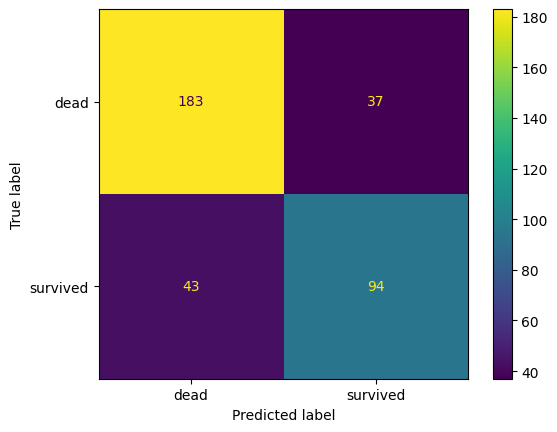

In [13]:
# Create a confusion matrix that compares the predicted labels with the correct labels of the test set
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

display_labels=['dead', 'survived']
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=display_labels)
disp.plot()
plt.show()

In [14]:
# Print a classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       220
           1       0.72      0.69      0.70       137

    accuracy                           0.78       357
   macro avg       0.76      0.76      0.76       357
weighted avg       0.77      0.78      0.77       357




# Feature Importance¶


In [15]:
##  Permutation Importance¶


In [16]:
feature_names = pipe.feature_names_in_
feature_names

array(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype=object)

In [17]:
from sklearn.inspection import permutation_importance


In [18]:
perm_importance = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=1066)

In [19]:
importances = perm_importance['importances_mean']
importances

array([ 0.08067227,  0.17507003,  0.06470588, -0.00168067,  0.03445378])

In [20]:
feature_importances = pd.Series(
    importances, index=feature_names
).sort_values(ascending=True)


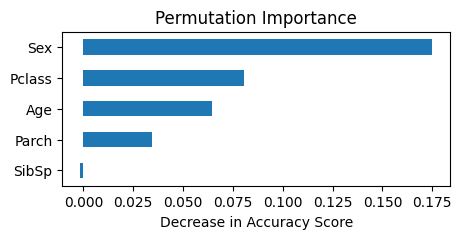

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 2))
feature_importances.plot.barh(ax=ax)
plt.xlabel("Decrease in Accuracy Score")
plt.title('Permutation Importance')
plt.show()


## Decision Tree Feature Importance¶


In [22]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex']),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Age'])])),
                ('classifier', DecisionTreeClassifier())])

In [23]:
feature_names = pipe[:-1].get_feature_names_out()
feature_names

array(['ohe__Sex_female', 'ohe__Sex_male', 'imputer__Age',
       'remainder__Pclass', 'remainder__SibSp', 'remainder__Parch'],
      dtype=object)

In [24]:
importances = pipe['classifier'].feature_importances_
importances

array([0.35787548, 0.        , 0.35174745, 0.12680285, 0.12092918,
       0.04264504])

In [25]:
feature_importances = pd.Series(
    importances, index=feature_names
).sort_values(ascending=True)


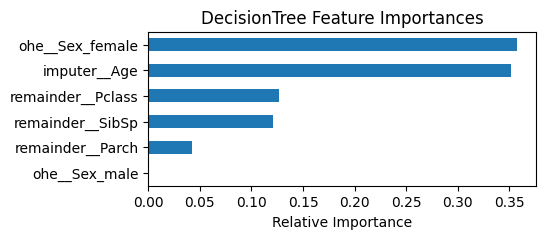

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 2))
feature_importances.plot.barh(ax=ax)
plt.xlabel("Relative Importance")
plt.title('DecisionTree Feature Importances')
plt.show()
